# Notebook 1: Extract LFP

### Overview
This Jupyter notebook focuses on extracting local field potential (LFP) traces from Spikegadgets `.rec` files, specifically for neuroscience research related to social competition trials. The notebook includes procedures for preprocessing and synchronizing raw electrophysiology data with corresponding video data and computes various metrics, including Z-scored LFPs.

### Inputs & Data Sources
- **Electrophysiology and LFP Parameters**: Constants like `EPHYS_SAMPLING_RATE`, `LFP_SAMPLING_RATE`, `TRIAL_DURATION`, etc., define basic parameters for LFP data processing.
- **Recording Information**: Stream IDs (`ECU_STREAM_ID`, `TRODES_STREAM_ID`), recording extension (`RECORDING_EXTENSION`), and paths to recording directories (`ALL_SESSION_DIR`).
- **DataFrames for Mapping and Timestamps**: `CHANNEL_MAPPING_DF` for channel mapping, and `TONE_TIMESTAMP_DF` for tone timestamps, loaded from external sources.
- **Constants for DataFrame Columns**: Names for various columns in the DataFrame, defined in an all-caps snake case format, such as `EPHYS_INDEX_COL`, `LFP_INDEX_COL`, etc.

### Output & Utility
- **Processed Data**: The notebook outputs processed data, particularly the Z-scored LFP traces, which are critical for further analysis in neuroscience research.
- **Data Files**: Outputs are saved in various formats (`CSV`, `Pickle`) in a specified output directory (`OUTPUT_DIR`).
- **Visualization**: While not explicitly mentioned, the notebook has the potential for data visualization (plots) based on processed LFP data.

### Processing Workflow
1. **LFP Extraction and Preprocessing**: 
    - Iterates through recording sessions to process `.rec` files.
    - Applies a series of preprocessing steps like bandpass filtering, notch filtering, resampling, and Z-scoring on the LFP data.
    - Exception handling for cases where the recording doesn't contain specified stream IDs.

2. **DataFrame Manipulation and Merging**:
    - Filtering `TONE_TIMESTAMP_DF` for trials with obtained LFP.
    - Addition of trial numbers and merging with `CHANNEL_MAPPING_DF`.
    - Dropping unnecessary columns and restructuring for analysis.

3. **LFP Trace Extraction for Each Trial and Brain Region**: 
    - Linking LFP calculations with trials.
    - Creating new rows for each brain region, extracting baseline, trial, and combined LFP traces.
    - Results in a comprehensive DataFrame that combines trial information with corresponding LFP traces.

4. **Data Storage**:
    - Saving processed DataFrame in both `CSV` and `Pickle` formats for easy access and future use.

### Usage Notes
- The notebook is project-specific and tailored for a particular dataset structure, requiring modifications for different data formats.
- Users should ensure file paths and directory names match their project's structure and adjust constants and parameters as needed for their specific analysis requirements.
- The notebook forms a part of a larger research framework, thus necessitating compatibility checks with other components of the project.

### Dependencies
- Python Libraries: `sys`, `os`, `glob`, `numpy`, `pandas`, `spikeinterface`
- External Data: Channel mapping and tone timestamp files, along with Spikegadgets `.rec` files.

### Customization and Scalability
- The notebook's modular design allows for easy adaptation to different datasets or extensions to include additional processing steps.
- Functions and processing steps are clearly demarcated, facilitating straightforward updates or enhancements.

### Conclusion
This notebook is a vital tool in the preprocessing and analysis of LFP data from Spikegadgets recordings, integral to neuroscience research focused on social competition trials. It offers a structured approach to handle, process, and store electrophysiological data, ensuring reproducibility and efficiency in research workflows.

In [1]:
import sys
import os
import git

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'/nancy/user/riwata/projects/reward_comp_ext'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
# Imports of all used packages and libraries
import glob
import numpy as np
import pandas as pd

In [6]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

In [7]:
from utilities import helper

## Inputs & Data

Explanation of each input and where it comes from.

In [8]:
EPHYS_SAMPLING_RATE = 20000
LFP_SAMPLING_RATE = 1000
LFP_RESAMPLE_RATIO = EPHYS_SAMPLING_RATE / LFP_SAMPLING_RATE
TRIAL_DURATION = 10
FRAME_RATE = 22
ECU_STREAM_ID = "ECU"
TRODES_STREAM_ID = "trodes"
LFP_FREQ_MIN = 0.5
LFP_FREQ_MAX = 300
ELECTRIC_NOISE_FREQ = 60
RECORDING_EXTENTION = "*.rec"

In [9]:
EPHYS_INDEX_COL = "time_stamp_index"
LFP_INDEX_COL = "lfp_index"
EPHYS_TIMESTAMP_COL = "time"
RECORDING_FILE_COL = "recording_file"
RECORDING_DIR_COL = "recording_dir"
BASELINE_LFP_INDEX_RANGE_COL = "baseline_lfp_index_range"
TRIAL_LFP_INDEX_RANGE_COL = "trial_lfp_index_range"
BASELINE_EPHYS_INDEX_RANGE_COL = "baseline_ephys_index_range"
TRIAL_EPHYS_INDEX_RANGE_COL = "trial_ephys_index_range"
BASELINE_VIDEOFRAME_RANGE_COL = "baseline_videoframe_range"
TRIAL_VIDEOFRAME_RANGE_COL = "trial_videoframe_range"
CURRENT_SUBJECT_COL = "current_subject"
ALL_CH_LFP_COL = "all_ch_lfp"
SUBJECT_COL = "Subject"
TRIAL_NUMBER_COL = "trial_number"
SPIKE_INTERFACE_COL = "spike_interface"
EIB_COL = "eib"

In [10]:
LFP_TRACE_COLUMNS = ["session_dir", "recording", "metadata_dir", "metadata_file", "first_dtype_name", "first_item_data", "last_dtype_name", "last_item_data", 'all_subjects', 'current_subject', 'filename']
VIDEO_COLUMNS = ['session_dir', 'recording', 'metadata_dir', 'metadata_file',
      'session_path', 'first_dtype_name', 'first_item_data',
       'all_subjects', 'current_subject', 'filename']

In [11]:
# NOTE: Change based on individual project data location

# Spreadsheet of channel mapping
CHANNEL_MAPPING_DF = pd.read_excel(os.path.join(git_root, "data/rce3_per_subject_channel_mapping.xlsx"))
# Spreadsheet of tone time
SPIKEGADGETS_EXTRACTED_DF = pd.read_pickle("../2024_05_21_extract_timestamps/proc/rce_pilot_3_alone_comp_00_trodes_metadata.pkl")

In [12]:
CHANNEL_MAPPING_DF.head()

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD,notes
0,NaN,3.1,NaN,31,30,29,28,23,16,17,18,19,NaN
1,NaN,3.3,NaN,15,14,13,12,21,15,14,13,12,NaN
2,NaN,3.4,NaN,31,30,29,28,22,16,17,18,19,NaN
3,NaN,4.2,NaN,15,14,13,12,5,15,14,13,12,NaN
4,NaN,4.3,NaN,31,30,29,28,14,16,17,18,19,NaN


In [13]:
# NOTE: Change based on individual project data location
# Where all the recording files are being saved
# ALL_SESSION_DIR = glob.glob("/scratch/back_up/reward_competition_extention/data/standard/2023_06_*/*.rec")
ALL_SESSION_DIR = glob.glob("/scratch/back_up/reward_competition_extention/data/rce_cohort_3/alone_comp/*.rec")[:2]

In [14]:
ALL_SESSION_DIR

['/scratch/back_up/reward_competition_extention/data/rce_cohort_3/alone_comp/20240323_144517_alone_comp_subj_3-1_and_3-4.rec',
 '/scratch/back_up/reward_competition_extention/data/rce_cohort_3/alone_comp/20240323_122227_alone_comp_subj_5-2_and_5-3.rec']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [15]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_3_alone_comp"

In [16]:
FULL_LFP_TRACES_PKL = "{}_01_lfp_traces_and_frames.pkl".format(OUTPUT_PREFIX)

# Functions

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [17]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




# Extracting the LFP

In [18]:
SPIKEGADGETS_EXTRACTED_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps
0,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,"[3.1, 3.3]",1830734,65425515,"[1384, 2770, 4156, 4156, 5542, 6928, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076..."
1,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,"[3.1, 3.3]",1830734,65425515,"[1332, 1384, 2770, 4156, 5267, 5542, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076..."
2,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,"[3.1, 3.3]",1830734,65425515,"[1384, 2770, 4156, 4156, 5542, 6928, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076..."
3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,"[3.1, 3.3]",1830734,65425515,"[1332, 1384, 2770, 4156, 5267, 5542, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076..."
4,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 4...","[[0, 79], [84, 92], [92, 132], [145, 175], [25...","[[0, 79], [79, 186], [188, 191], [191, 268], [...",20240320_171038_alone_comp_subj_4-2_and_4-3.1....,/scratch/back_up/reward_competition_extention/...,20240320_171038_alone_comp_subj_4-2_t6b6_merged,4.2,"[4.2, 4.3]",2067718,66452444,"[1384, 2770, 4156, 4156, 5541, 6927, 6927, 831...","[[0, 79744], [1280158, 1480161], [3280184, 348...","[[0, 79744], [85741, 92941], [93544, 134344], ...","[[0, 79744], [80141, 188142], [188942, 191545]..."


In [19]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in ALL_SESSION_DIR:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, RECORDING_EXTENTION)):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id=ECU_STREAM_ID)
            current_recording = se.read_spikegadgets(recording_path, stream_id=TRODES_STREAM_ID)
            print(recording_basename)

            # Preprocessing the LFP
            current_recording = sp.notch_filter(current_recording, freq=ELECTRIC_NOISE_FREQ)
            current_recording = sp.bandpass_filter(current_recording, freq_min=LFP_FREQ_MIN, freq_max=LFP_FREQ_MAX)
            current_recording = sp.resample(current_recording, resample_rate=LFP_SAMPLING_RATE)            
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except Exception as error:
            # handle the exception
            print("An exception occurred:", error) # An exception occurred: division by zero
        
    




An exception occurred: stream_id trodes is not in ['ECU']
20240323_144517_alone_comp_subj_3-1_t5b5_merged
20240323_144517_alone_comp_subj_3-4_t6b6_merged
20240323_122227_alone_comp_subj_5-2_t6b6_merged
An exception occurred: stream_id trodes is not in ['ECU']
20240323_122227_alone_comp_subj_5-3_t5b5_merged


- Combining LFP traces with metadata

In [20]:
# Filtering for rows that are the metadata for the raw recordings
# lfp_trace_condition = (SPIKEGADGETS_EXTRACTED_DF["recording"].isin(recording_name_to_all_ch_lfp) & (SPIKEGADGETS_EXTRACTED_DF["metadata_dir"] == "raw") & (SPIKEGADGETS_EXTRACTED_DF["metadata_file"] == "timestamps"))
lfp_trace_condition = (SPIKEGADGETS_EXTRACTED_DF["recording"].isin(recording_name_to_all_ch_lfp))

SPIKEGADGETS_LFP_DF = SPIKEGADGETS_EXTRACTED_DF[lfp_trace_condition].copy().reset_index(drop=True)
# Removing the columns that are not needed
# SPIKEGADGETS_LFP_DF = SPIKEGADGETS_LFP_DF[LFP_TRACE_COLUMNS]

In [21]:
# Adding the LFP traces to the metadata dataframe
SPIKEGADGETS_LFP_DF["all_ch_lfp"] = SPIKEGADGETS_LFP_DF["recording"].map(recording_name_to_all_ch_lfp)

## Get the timestamp of the LFP

In [22]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,all_ch_lfp
0,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 3407, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...
1,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 4155, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...
2,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 3407, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...
3,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 4155, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...
4,20240323_144517_alone_comp_subj_3-1_and_3-4,"[[0, 473], [1673, 1872], [3669, 3868], [4867, ...","[[0, 473], [549, 565], [568, 580], [814, 816],...","[[0, 473], [475, 481], [483, 486], [486, 487],...",20240323_144517_alone_comp_subj_3-1_and_3-4.1....,/scratch/back_up/reward_competition_extention/...,20240323_144517_alone_comp_subj_3-1_t5b5_merged,3.1,"[3.1, 3.4]",1293017,65913341,"[1384, 1384, 2770, 2770, 4155, 4155, 5541, 578...","[[0, 956078], [2156493, 2356495], [4156519, 43...","[[0, 956078], [1031478, 1047481], [1049679, 10...","[[0, 956078], [956475, 964475], [964877, 96787...",ResampleRecording: 32 channels - 1.0kHz - 1 se...


In [23]:
# Getting the timestamps for the LFP traces by resampling the raw timestamps
SPIKEGADGETS_LFP_DF["LFP_timestamps"] = SPIKEGADGETS_LFP_DF.apply(lambda row: np.arange(0, row["all_ch_lfp"].get_total_samples()*LFP_RESAMPLE_RATIO, LFP_RESAMPLE_RATIO, dtype=int), axis=1)

# SPIKEGADGETS_LFP_DF["LFP_timestamps"] = SPIKEGADGETS_LFP_DF.apply(lambda row: np.arange(row["first_timestamp"]-row["first_timestamp"], row["last_timestamp"]-row["first_timestamp"], LFP_RESAMPLE_RATIO, dtype=np.int32), axis=1)
                                                                  
                                                                  


In [24]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,all_ch_lfp,LFP_timestamps
0,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 3407, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
1,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 4155, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
2,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 3407, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
3,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 4155, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
4,20240323_144517_alone_comp_subj_3-1_and_3-4,"[[0, 473], [1673, 1872], [3669, 3868], [4867, ...","[[0, 473], [549, 565], [568, 580], [814, 816],...","[[0, 473], [475, 481], [483, 486], [486, 487],...",20240323_144517_alone_comp_subj_3-1_and_3-4.1....,/scratch/back_up/reward_competition_extention/...,20240323_144517_alone_comp_subj_3-1_t5b5_merged,3.1,"[3.1, 3.4]",1293017,65913341,"[1384, 1384, 2770, 2770, 4155, 4155, 5541, 578...","[[0, 956078], [2156493, 2356495], [4156519, 43...","[[0, 956078], [1031478, 1047481], [1049679, 10...","[[0, 956078], [956475, 964475], [964877, 96787...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."


In [25]:
SPIKEGADGETS_LFP_DF["all_ch_lfp"].iloc[0]

ResampleRecording: 32 channels - 1.0kHz - 1 segments - 3,178,604 samples 
                   3,178.60s (52.98 minutes) - int16 dtype - 194.01 MiB

In [26]:
SPIKEGADGETS_LFP_DF["LFP_timestamps"].iloc[0][0]


0

In [27]:
SPIKEGADGETS_LFP_DF["LFP_timestamps"].iloc[0].shape

(3178604,)

## Adding the channel mapping

In [29]:
CHANNEL_MAPPING_DF = CHANNEL_MAPPING_DF.drop(columns=[col for col in CHANNEL_MAPPING_DF.columns if "eib" in col], errors="ignore")

In [30]:
for col in CHANNEL_MAPPING_DF.columns:
    if "spike_interface" in col:
        CHANNEL_MAPPING_DF[col] = CHANNEL_MAPPING_DF[col].fillna(0)
        CHANNEL_MAPPING_DF[col] = CHANNEL_MAPPING_DF[col].astype(int).astype(str)

In [31]:
CHANNEL_MAPPING_DF

,Cohort,Subject,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD,notes
0,NaN,3.1,23,16,17,18,19,NaN
1,NaN,3.3,21,15,14,13,12,NaN
2,NaN,3.4,22,16,17,18,19,NaN
3,NaN,4.2,5,15,14,13,12,NaN
4,NaN,4.3,14,16,17,18,19,NaN
5,NaN,4.4,22,15,14,13,12,NaN
6,NaN,5.2,22,15,14,13,12,mayb 18 or 26
7,NaN,5.3,10,15,14,13,12,mayb 10 or 26
8,NaN,5.4,22,16,17,18,19,no good mpfc channels from spike sorting


- Adding all the brain region to ch information

In [32]:
CHANNEL_MAPPING_DF[SUBJECT_COL] = CHANNEL_MAPPING_DF[SUBJECT_COL].astype(str)

- Merging the recording and the channel dataframes

In [33]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,all_ch_lfp,LFP_timestamps
0,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 3407, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
1,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 4155, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
2,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 3407, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
3,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,65630624,"[-2, -2, 1384, 2770, 4155, 4155, 5541, 6927, 6...","[[0, 68667], [1269082, 1469087], [3269109, 346...","[[0, 68667], [94470, 96870], [106670, 112071],...","[[0, 68667], [198471, 199271], [203071, 205469...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
4,20240323_144517_alone_comp_subj_3-1_and_3-4,"[[0, 473], [1673, 1872], [3669, 3868], [4867, ...","[[0, 473], [549, 565], [568, 580], [814, 816],...","[[0, 473], [475, 481], [483, 486], [486, 487],...",20240323_144517_alone_comp_subj_3-1_and_3-4.1....,/scratch/back_up/reward_competition_extention/...,20240323_144517_alone_comp_subj_3-1_t5b5_merged,3.1,"[3.1, 3.4]",1293017,65913341,"[1384, 1384, 2770, 2770, 4155, 4155, 5541, 578...","[[0, 956078], [2156493, 2356495], [4156519, 43...","[[0, 956078], [1031478, 1047481], [1049679, 10...","[[0, 956078], [956475, 964475], [964877, 96787...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."


In [34]:
SPIKEGADGETS_LFP_DF = pd.merge(SPIKEGADGETS_LFP_DF, CHANNEL_MAPPING_DF, left_on=CURRENT_SUBJECT_COL, right_on=SUBJECT_COL, how="left")



In [35]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,all_ch_lfp,LFP_timestamps,Cohort,Subject,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD,notes
0,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,5.2,22,15,14,13,12,mayb 18 or 26
1,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,5.2,22,15,14,13,12,mayb 18 or 26
2,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,5.3,10,15,14,13,12,mayb 10 or 26
3,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,5.3,10,15,14,13,12,mayb 10 or 26
4,20240323_144517_alone_comp_subj_3-1_and_3-4,"[[0, 473], [1673, 1872], [3669, 3868], [4867, ...","[[0, 473], [549, 565], [568, 580], [814, 816],...","[[0, 473], [475, 481], [483, 486], [486, 487],...",20240323_144517_alone_comp_subj_3-1_and_3-4.1....,/scratch/back_up/reward_competition_extention/...,20240323_144517_alone_comp_subj_3-1_t5b5_merged,3.1,"[3.1, 3.4]",1293017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,3.1,23,16,17,18,19,NaN


# Getting the channel specific LFP traces

- Linking up all LFP calculations with all the trials

- Extracting the traces for each brain region

In [36]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,all_ch_lfp,LFP_timestamps,Cohort,Subject,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD,notes
0,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,5.2,22,15,14,13,12,mayb 18 or 26
1,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-2_t6b6_merged,5.2,"[5.2, 5.3]",2058017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,5.2,22,15,14,13,12,mayb 18 or 26
2,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1267, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 112], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.1....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,5.3,10,15,14,13,12,mayb 10 or 26
3,20240323_122227_alone_comp_subj_5-2_and_5-3,"[[2, 69], [1268, 1468], [3263, 3464], [4461, 4...","[[2, 69], [96, 97], [107, 113], [238, 263], [2...","[[2, 69], [199, 199], [204, 206], [209, 215], ...",20240323_122227_alone_comp_subj_5-2_and_5-3.2....,/scratch/back_up/reward_competition_extention/...,20240323_122227_alone_comp_subj_5-3_t5b5_merged,5.3,"[5.2, 5.3]",2058017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,5.3,10,15,14,13,12,mayb 10 or 26
4,20240323_144517_alone_comp_subj_3-1_and_3-4,"[[0, 473], [1673, 1872], [3669, 3868], [4867, ...","[[0, 473], [549, 565], [568, 580], [814, 816],...","[[0, 473], [475, 481], [483, 486], [486, 487],...",20240323_144517_alone_comp_subj_3-1_and_3-4.1....,/scratch/back_up/reward_competition_extention/...,20240323_144517_alone_comp_subj_3-1_t5b5_merged,3.1,"[3.1, 3.4]",1293017,...,ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",NaN,3.1,23,16,17,18,19,NaN


In [37]:
SPIKEGADGETS_LFP_DF["all_channels"] = SPIKEGADGETS_LFP_DF["all_ch_lfp"].apply(lambda x: x.get_channel_ids())

In [38]:
SPIKEGADGETS_LFP_DF["region_channels"] = SPIKEGADGETS_LFP_DF[["spike_interface_mPFC", "spike_interface_vHPC", "spike_interface_BLA", "spike_interface_LH", "spike_interface_MD"]].to_dict('records')

In [39]:
SPIKEGADGETS_LFP_DF["region_channels"] = SPIKEGADGETS_LFP_DF["region_channels"].apply(lambda x: sorted(x.items(), key=lambda item: int(item[1])))


In [40]:
SPIKEGADGETS_LFP_DF["region_channels"].iloc[0]

[('spike_interface_MD', '12'),
 ('spike_interface_LH', '13'),
 ('spike_interface_BLA', '14'),
 ('spike_interface_vHPC', '15'),
 ('spike_interface_mPFC', '22')]

In [41]:
SPIKEGADGETS_LFP_DF["all_channels"].iloc[0]

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

In [42]:
example_spike_interface = SPIKEGADGETS_LFP_DF["all_ch_lfp"].iloc[0]


In [51]:
start_frame = 10*60*1000
stop_frame = 15*60*1000

In [52]:
start_frame

600000

In [53]:
stop_frame

900000

In [54]:
example_spike_interface.get_num_samples()

3178604

In [56]:
SPIKEGADGETS_LFP_DF["all_region_lfp_trace"] = SPIKEGADGETS_LFP_DF.apply(lambda row: row[ALL_CH_LFP_COL].get_traces(start_frame=start_frame, end_frame=stop_frame).T, axis=1)

In [57]:
SPIKEGADGETS_LFP_DF["per_region_lfp_trace"] = SPIKEGADGETS_LFP_DF.apply(lambda row: dict(zip([t for t in row["all_channels"]], row["all_region_lfp_trace"])), axis=1)

In [61]:
SPIKEGADGETS_LFP_DF = SPIKEGADGETS_LFP_DF.drop_duplicates(subset=["recording"])

In [62]:
SPIKEGADGETS_LFP_DF["per_region_lfp_trace"]

0    {'0': [2639, 2688, 2786, 2843, 2967, 3125, 318...
2    {'0': [799, 964, 1101, 1167, 1280, 1395, 1345,...
4    {'0': [573, 633, 716, 812, 962, 1107, 1131, 10...
6    {'0': [243, 321, 154, -45, -31, 103, 174, 221,...
Name: per_region_lfp_trace, dtype: object

In [73]:
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

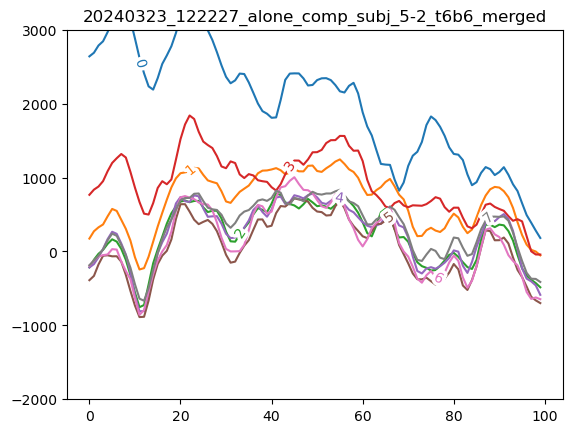

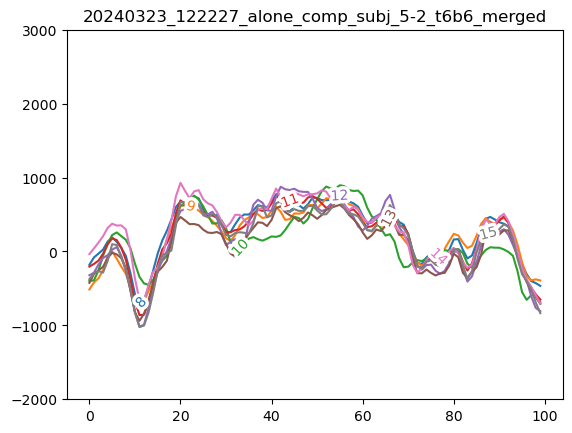

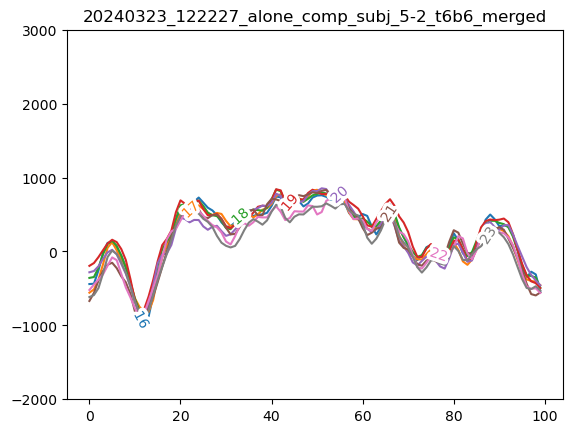

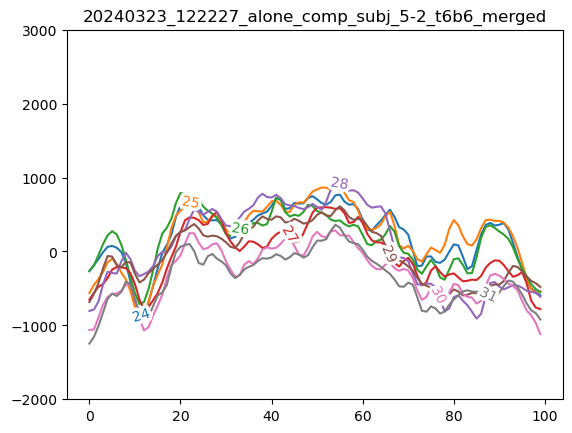

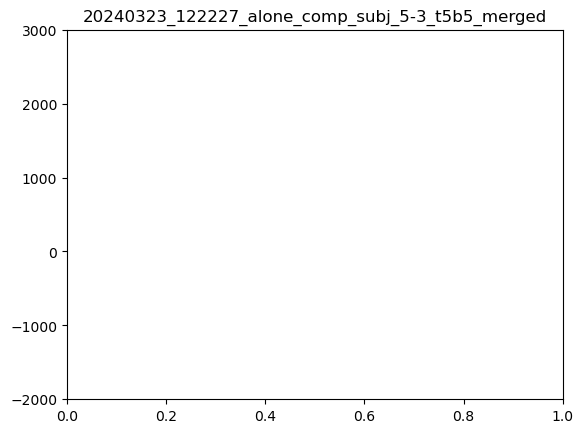

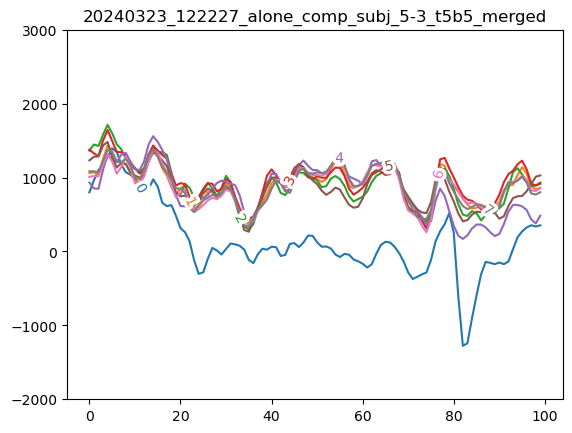

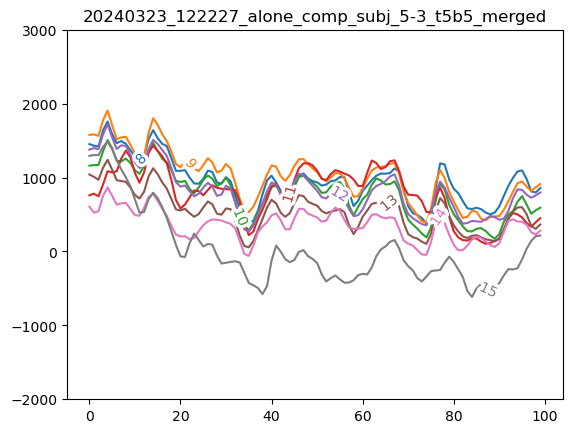

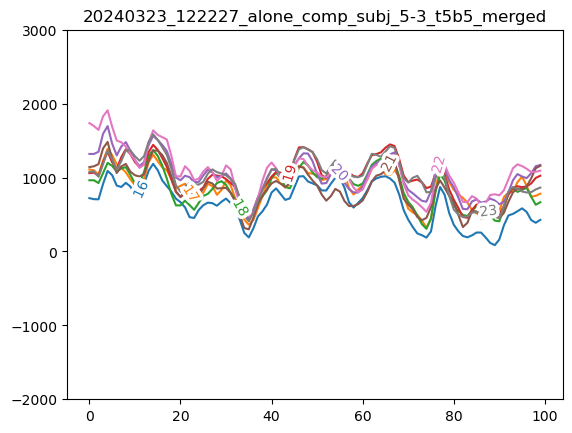

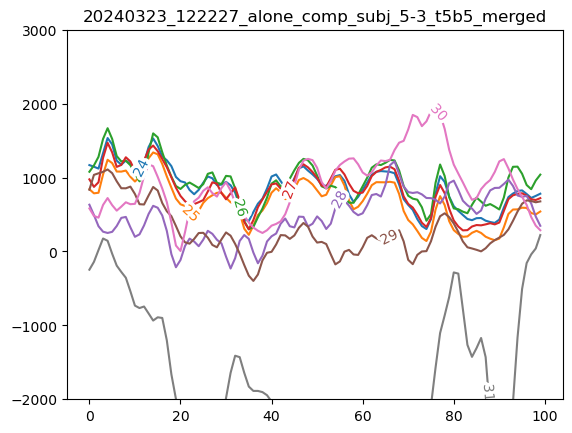

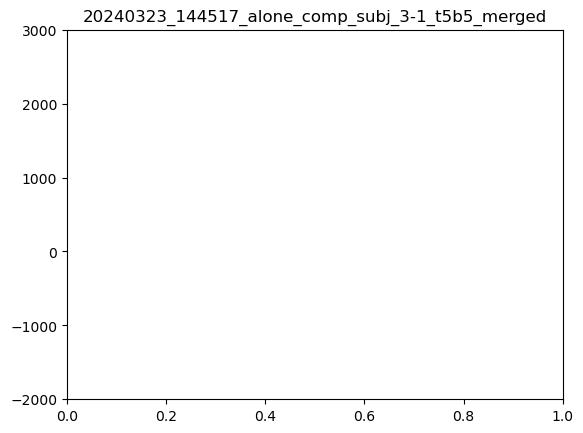

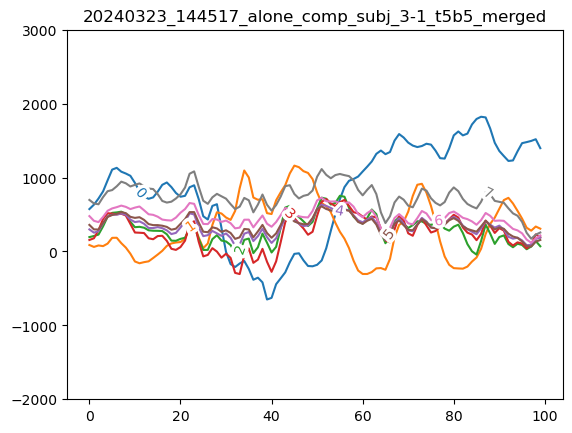

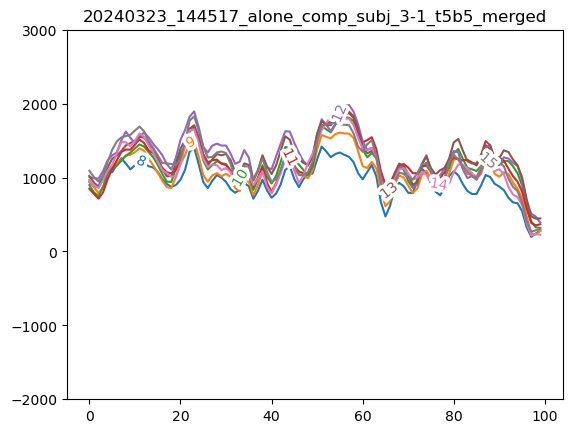

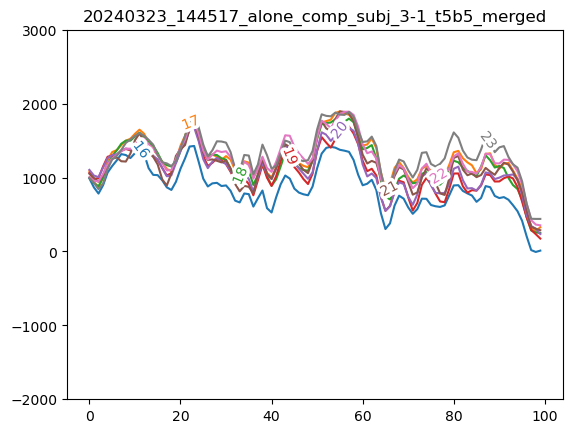

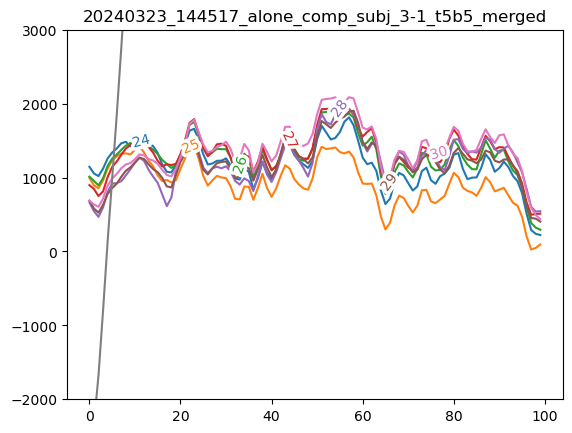

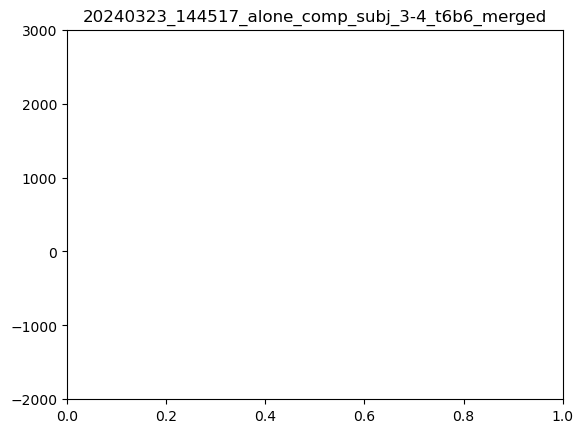

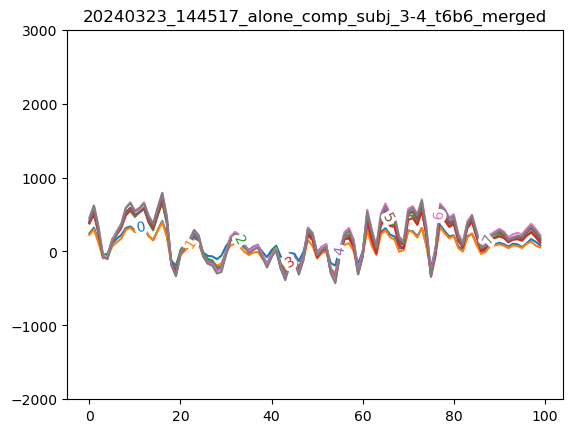

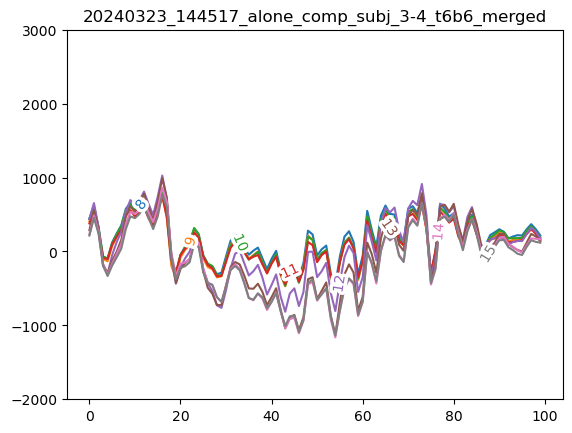

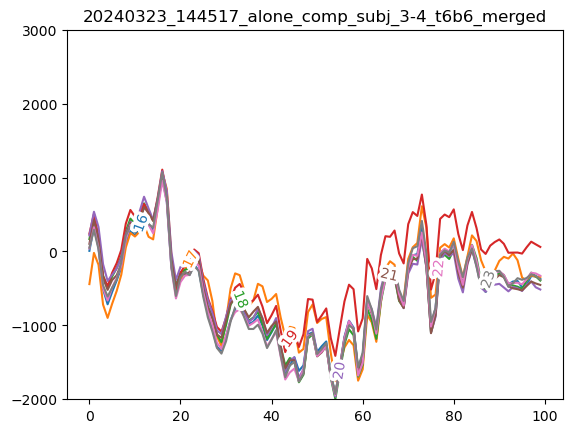

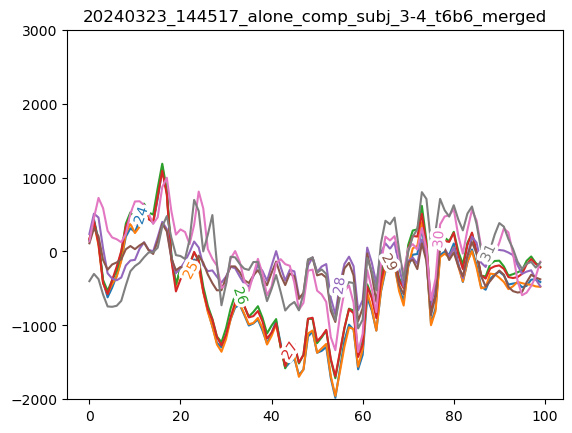

In [83]:
# Assuming SPIKEGADGETS_LFP_DF is your DataFrame
plot_count = 0  # Counter to keep track of how many plots are in the current subplot
fig, ax = plt.subplots()  # Create the initial figure and axes

for index, row in SPIKEGADGETS_LFP_DF.iterrows():
    for channel, trace in row["per_region_lfp_trace"].items():
        plt.ylim(-2000, 3000)
        if plot_count == 8:  # Check if 4 lines have been plotted
            labelLines(ax.get_lines(), zorder=2.5)  # Label the lines on the old plot
            plt.title(row["recording"])  # Set the title for the old plot
            fig, ax = plt.subplots()  # Create a new subplot
            plot_count = 0  # Reset the counter
        plt.plot(trace[:100], label=channel)  # Plot the trace
        plot_count += 1  # Increment the plot counter

    # Add labels and titles to the last subplot after the loop
    labelLines(ax.get_lines(), zorder=2.5)
    plt.title(row["recording"])
    plt.show()

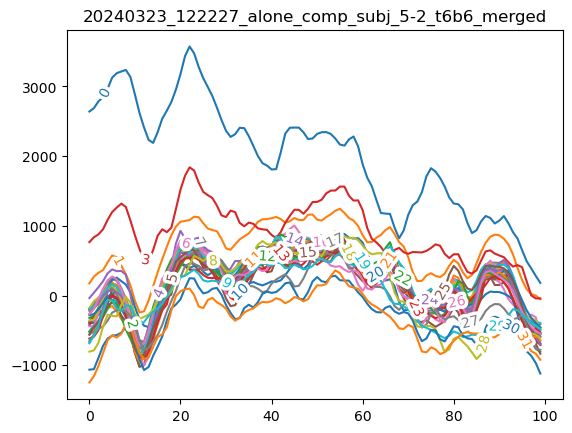

In [77]:
for index, row in SPIKEGADGETS_LFP_DF.iterrows():
    fig, ax = plt.subplots()
    for channel, trace in row["per_region_lfp_trace"].items():
        plt.plot(trace[:100], label=channel)
    
    labelLines(ax.get_lines(), zorder=2.5)
    plt.title(row["recording"])
    break

In [ ]:
SPIKEGADGETS_FINAL_DF = pd.concat([SPIKEGADGETS_LFP_DF.copy(), SPIKEGADGETS_LFP_DF['per_region_lfp_trace'].apply(pd.Series).copy()], axis=1)

In [ ]:
SPIKEGADGETS_FINAL_DF.head()

# Reorganizing the columns

In [ ]:
SPIKEGADGETS_FINAL_DF.columns

In [ ]:
SPIKEGADGETS_FINAL_DF = SPIKEGADGETS_FINAL_DF.drop(columns=["all_channels", "all_region_lfp_trace", "per_region_lfp_trace", "region_channels", "all_ch_lfp"], errors="ignore")
SPIKEGADGETS_FINAL_DF = SPIKEGADGETS_FINAL_DF.drop(columns=[col for col in SPIKEGADGETS_FINAL_DF.columns if "spike_interface" in col], errors="ignore")
SPIKEGADGETS_FINAL_DF = SPIKEGADGETS_FINAL_DF.rename(columns={col: col.lower() for col in SPIKEGADGETS_LFP_DF.columns})

In [ ]:
sorted_columns = sorted(SPIKEGADGETS_FINAL_DF.columns
, key=lambda x: x.split("_")[-1])

In [ ]:
SPIKEGADGETS_FINAL_DF = SPIKEGADGETS_FINAL_DF[sorted_columns].copy()

In [ ]:
SPIKEGADGETS_FINAL_DF.head()

In [ ]:
SPIKEGADGETS_FINAL_DF.shape

In [ ]:
SPIKEGADGETS_FINAL_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [ ]:
raise ValueError("Stop here")